In [1]:
##Parcial 2 - Ashley Durán

In [2]:
#Aquí importamos los paquetes que necesitamos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [3]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

In [4]:
#Importamos la base con los datos históricos diarios de la TRM
TRM = "TRMdatos"
base_TRM = pd.read_csv(TRM, header=0, parse_dates=True, usecols= [0,2])
base_TRM.index = pd.to_datetime(base_TRM.VIGENCIADESDE, format="%d/%m/%Y")


#Establecemos una transformación de los datos diarios a datos mensuales
#e indicamos que se tome el último dato del mes como referencia
data_TRM = base_TRM.resample(rule = 'M').last()


#Necesitamos delimitar la base hasta el 2018
inicio1 = pd.to_datetime("1991-12-02").date()
final1 = pd.to_datetime("2018-12-31").date()
data2_TRM = data_TRM.loc[inicio1:final1]

In [5]:
data_TRM

,VALOR,VIGENCIADESDE
VIGENCIADESDE,,
1991-12-31,632.37,31/12/1991
1992-01-31,644.27,31/01/1992
1992-02-29,636.54,29/02/1992
1992-03-31,641.59,31/03/1992
1992-04-30,653.83,30/04/1992
...,...,...
2020-07-31,3739.49,31/07/2020
2020-08-31,3760.38,29/08/2020
2020-09-30,3878.94,30/09/2020


In [6]:
data2_TRM

,VALOR,VIGENCIADESDE
VIGENCIADESDE,,
1991-12-31,632.37,31/12/1991
1992-01-31,644.27,31/01/1992
1992-02-29,636.54,29/02/1992
1992-03-31,641.59,31/03/1992
1992-04-30,653.83,30/04/1992
...,...,...
2018-08-31,3027.39,31/08/2018
2018-09-30,2972.18,29/09/2018
2018-10-31,3202.44,31/10/2018


In [7]:
#Utilice la serie mensual con informacion hasta 2018 : 12 para identificar por lo
#menos dos modelos ARMA para realizar pronosticos sobre la serie.

modelo = auto_arima(data2_TRM.VALOR.dropna(), start_p=1, start_q=1,
                      test='adf',       
                      max_p=4, max_q=4, 
                      d=None,       
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
modelo.summary()

#ARIMA (0,1,0) y ARIMA (1,1,0) porque tienen los menores AIC

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3733.257, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3730.784, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3731.263, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3731.312, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3732.413, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.755 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  325
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1863.392
Date:                Sun, 22 Nov 2020   AIC                           3730.784
Time:                        00:16:25   BIC                           3738.346
Sample:                             0   HQIC                          3733.802
                                - 325                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.0783      4.239      1.906      0.057      -0.229      16.386
sigma2      5793.7980    305.039     18.994      0.000    5195.933    6391.663
===================================================================================
Ljung-Box (Q):                       79.30   Jarque-Bera (JB):                83.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.98   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
#Pronostique la tasa de cambio desde Enero a Septiembre de 2019 (mes a mes,rolling window). 
#Reporte alguna metrica de desempeño de pronostico y compare los modelos construidos en el punto anterior. 
#Utilice el test de Diebold y Mariano para comparar el desempeño de los modelos

In [9]:
inicial = pd.Timestamp("1991-12-31")
final = pd.Timestamp("2018-12-31")

In [10]:
rollingw1=[]
for i in range(9):
    inicio = inicial + pd.DateOffset(months=i)
    fin = final + pd.DateOffset(months=i)
    ventana = data_TRM.loc[inicio:fin,"VALOR"]
    modelo = SARIMAX(ventana, order = (0,1,0))
    modelo_fit = modelo.fit()
    predic = modelo_fit.get_forecast(steps=1).predicted_mean
    rollingw1.append(predic[0])

In [11]:
rollingw2=[]
for i in range(9):
    inicio = inicial + pd.DateOffset(months=i)
    fin = final + pd.DateOffset(months=i)
    ventana2 = data_TRM.loc[inicio:fin,"VALOR"]
    modelo = SARIMAX(ventana2, order = (1,1,0))
    modelo_fit = modelo.fit()
    predic = modelo_fit.get_forecast(steps=1).predicted_mean
    rollingw2.append(predic[0])

In [12]:
#Traemos de nuevo la base original
TRM2 = "TRM2"
base2_TRM = pd.read_csv(TRM2, header=0, parse_dates=True, usecols= [0,2])
base2_TRM.index = pd.to_datetime(base2_TRM.VIGENCIADESDE, format="%d/%m/%Y")
data2_TRM = base_TRM.resample(rule = 'M').last()

In [13]:
#Definimos como actual la base con los datos observados
actual = data2_TRM.loc["2019-01-31":"2019-09-30","VALOR"]

In [14]:
def mape(actual, rollingw): 
    actual, rollingw = np.array(actual), np.array(rollingw)
    return np.mean(np.abs((actual - rollingw) / actual)) * 100

In [15]:
#Calculamos el Mean absolute percentage error
mape1 = mape(actual,rollingw1)
print(mape1)
mape2 = mape(actual, rollingw2)
print(mape2)

2.9763568696005067
2.954744941224447


In [16]:
#Calculamos el mean absolute error
mae_1 = mean_absolute_error(actual,rollingw1)

mae_2 = mean_absolute_error(actual,rollingw2)

print(mae_1)
print(mae_2)

96.89333333333333
96.09619696102274


In [17]:
def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "MAPE" and crit != "MAD" and crit != "poly"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)  
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")  
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
            is_actual_ok = compiled_regex(str(abs(actual)))
            is_pred1_ok = compiled_regex(str(abs(pred1)))
            is_pred2_ok = compiled_regex(str(abs(pred2)))
            if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):  
                msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
                rt = -1
                return (rt,msg)
        return (rt,msg)
    
    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np
    
    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []
    
    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()
    
    # Length of lists (as real numbers)
    T = float(len(actual_lst))
    
    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)    
    
    # Mean of d        
    mean_d = pd.Series(d_lst).mean()
    
    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)
    
    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')
    
    rt = dm_return(DM = DM_stat, p_value = p_value)
    
    return rt

In [18]:
#Considerando como Ho = Las predicciones tienen una precisión equivalente
rt = dm_test(actual,rollingw1,rollingw2,h = 1, crit="MSE")
print(rt)

dm_return(DM=-0.2348709709993388, p_value=0.8202089509943034)


In [19]:
mape = np.mean(np.abs((actual - rollingw1) / actual)) * 100
print(mape)

2.976356869600507


In [22]:
##PUNTO 2 ##

base_completa = pd.read_csv("Completa", header=0, parse_dates=True, index_col=0, usecols= [0,1,17])
base_completa.index = pd.to_datetime(base_completa.index, utc = True)

BFX = base_completa["Symbol"] == ".BFX"
indice_BFX = base_completa[BFX]


indice_BFX["retornos"] = np.log(indice_BFX["close_price"]).diff(periods=1)*100
indice_BFX = indice_BFX.dropna()


BFX_2017 = indice_BFX.loc[:"2017-12-29"]
BFX_2017 = BFX_2017.dropna()

indice_BFX=indice_BFX.dropna()

#base_BFX = BFX.loc[:"2017-12-30",["close_price","rv5_ss"]]
#BFX_2017.index = pd.to_datetime(BFX_2017.index, utc = True)

C:\Users\ashle\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Iteration:      1,   Func. Count:      6,   Neg. LLF: 6544.833091982618
Iteration:      2,   Func. Count:     16,   Neg. LLF: 6535.602105963577
Iteration:      3,   Func. Count:     24,   Neg. LLF: 6529.512339500711
Iteration:      4,   Func. Count:     32,   Neg. LLF: 6520.808954848859
Iteration:      5,   Func. Count:     40,   Neg. LLF: 6519.592302742311
Iteration:      6,   Func. Count:     47,   Neg. LLF: 6518.22433655166
Iteration:      7,   Func. Count:     54,   Neg. LLF: 6518.00399615176
Iteration:      8,   Func. Count:     61,   Neg. LLF: 6517.231371223112
Iteration:      9,   Func. Count:     67,   Neg. LLF: 6517.094070854051
Iteration:     10,   Func. Count:     73,   Neg. LLF: 6517.09143774478
Iteration:     11,   Func. Count:     79,   Neg. LLF: 6517.0914020504515
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6517.091401325999
            Iterations: 11
            Function evaluations: 80
            Gradient evaluations: 11


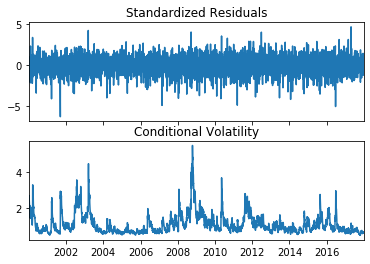

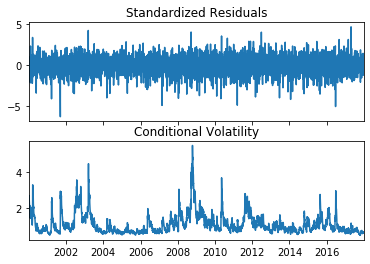

In [23]:
garch = arch_model(BFX_2017["retornos"], p = 1, q = 1, mean = "constant", 
                       vol = "GARCH", dist = "normal")

garch_fit = garch.fit(last_obs="2017-12-31")
print(garch_fit.summary())

garch_fit.plot()

In [24]:
gm=arch_model(indice_BFX["retornos"],p=1,q=1,mean = 'constant', vol = 'GARCH',dist="normal")
start_loc,end_loc=3006,4513
forecasts=dict()
   
garch_forecast = pd.DataFrame(forecasts).T*np.sqrt(252)

In [25]:
from arch.univariate import EWMAVariance, ZeroMean
r_BFX= ZeroMean(indice_BFX["retornos"])
rv_BFX = EWMAVariance(lam = 0.95)
ewma = r_BFX.fit()
Pewma = np.sqrt(ewma.forecast(horizon=1, start="2017-12-31").variance["2017-12-31":])*np.sqrt(252)